In [ ]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from tensorflow.keras import optimizers, layers, models
from matplotlib import pyplot as plt

## Data Prep

In [12]:
image_dir = "images/lattice_points"
train_files = [[], []]

for file in os.listdir(os.path.join(image_dir, "no")):
    if file.endswith(".jpg"):
        train_files[0].append(os.path.join(image_dir, "no", file))

for file in os.listdir(os.path.join(image_dir, "yes")):
    if file.endswith(".jpg"):
        train_files[1].append(os.path.join(image_dir, "yes", file))

In [13]:
all_images = []
all_labels = []

for i in range(2):
    for file in train_files[i]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
        img = cv2.Canny(img, 0, 255)
        
        img = img.astype(np.float32) / 255.0
        
        all_images.append(img)
        
        label = [0, 0]
        label[i] = 1
        all_labels.append(label)

all_images = np.array(all_images)[..., np.newaxis]
all_labels = np.array(all_labels)

In [14]:
print(all_images.shape, all_labels.shape)
print(all_images.max())
print(all_labels[0])

(823, 21, 21, 1) (823, 2)
1.0
[1 0]


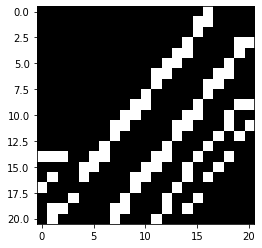

In [15]:
plt.figure()
plt.imshow(all_images[0][:, :, 0], cmap="gray")

In [18]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

train_indices = random.sample(range(len(all_images)), int(len(all_images) * 0.8))

for i in range(len(all_images)):
    if i in train_indices:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])
    else:
        valid_images.append(all_images[i])
        valid_labels.append(all_labels[i])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=4,
    height_shift_range=4)

## Initialize Network

In [21]:
model = models.Sequential()
model.add(layers.Dense(441, input_shape=(21, 21, 1)))

for i in range(2):
    for j in [3, 2, 1]:
        model.add(layers.Conv2D(16, j, activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    
model.add(layers.Dense(128, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizers.RMSprop(lr=1e-3), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 21, 21, 441)       882       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 19, 16)        63520     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 16)        1040      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 16)        272       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 16)          64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)         

In [23]:
def generate_data(train_images, train_labels, batch_size):
    gen = datagen.flow(train_images, train_labels, batch_size=batch_size)
    while True:
        x, y = gen.next()
        yield x, y

In [25]:
batch_size = train_images.shape[0]
epochs = 100

history = model.fit_generator(generate_data(train_images, train_labels, batch_size=batch_size),
                              steps_per_epoch=train_images.shape[0] / batch_size,
                              epochs=epochs, validation_data = (valid_images, valid_labels))

W0131 20:46:28.227305 4680961472 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 1.0 steps, validate on 165 samples
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2544 - categorical_accuracy: 0.8997 - val_loss: 0.5354 - val_categorical_accuracy: 0.7091
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.2321 - categorical_accuracy: 0.9164 - val_loss: 0.4101 - val_categorical_accuracy: 0.7818
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.2499 - categorical_accuracy: 0.9195 - val_loss: 0.5509 - val_categorical_accuracy: 0.7152
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.2671 - categorical_accuracy: 0.9103 - val_loss: 0.4212 - val_categorical_accuracy: 0.7879
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.2445 - categorical_accuracy: 0.9058 - val_loss: 0.4846 - val_categorical_accuracy: 0.7273
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.2287 - categorical_accuracy: 0.9103 - val_loss: 0.4695 - val_categorical_

1/1 [==============================] - 2s 2s/step - loss: 0.2090 - categorical_accuracy: 0.9286 - val_loss: 0.3079 - val_categorical_accuracy: 0.8727
Epoch 52/100
1/1 [==============================] - 2s 2s/step - loss: 0.2246 - categorical_accuracy: 0.9255 - val_loss: 0.4310 - val_categorical_accuracy: 0.7515
Epoch 53/100
1/1 [==============================] - 2s 2s/step - loss: 0.2267 - categorical_accuracy: 0.9149 - val_loss: 0.3590 - val_categorical_accuracy: 0.8182
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.2172 - categorical_accuracy: 0.9286 - val_loss: 0.4943 - val_categorical_accuracy: 0.7333
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 0.2096 - categorical_accuracy: 0.9286 - val_loss: 0.4014 - val_categorical_accuracy: 0.7636
Epoch 56/100
1/1 [==============================] - 2s 2s/step - loss: 0.2317 - categorical_accuracy: 0.9286 - val_loss: 0.3910 - val_categorical_accuracy: 0.7697
Epoch 57/100
1/1 [=================

In [26]:
model_json = model.to_json()
with open("lattice_points_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lattice_points_model.h5")